

# 0050 Price Prediction

The goal of this case study is tu use classification based models to predict whether the current signal is **buy or sell** depending on the short term vs long term price.

## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1)
    * [4.2. Preparing classification data](#3.2)
    * [4.3. Feature Engineering-Constructing Technical Indicators](#3.3)
    * [4.4.Data Visualisation](#3.4)
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split](#4.1)
    * [5.2. Test Options and Evaluation Metrics](#4.2)
    * [5.3. Compare Models and Algorithms](#4.3)
* [6. Model Tuning and Grid Search](#5)  
* [7. Finalize the Model](#6)  
    * [7.1. Results on test dataset](#6.1)
    * [7.1. Variable Intuition/Feature Selection](#6.2)
* [8. Backtesting](#7)     


<a id='0'></a>
# 1. Problem Definition

The problem of predicting a buy or sell signal for a trading strategy is defined in the
classification framework, where the predicted variable has a value of 1 for buy and 0
for sell.

The buy or sell signal are decided on the basis on the comparison of short term vs. long
term price.

For the purpose of presented case study, we get the data from yfinance

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [1]:
!pip install tensorflow
#!pip install tensorflow-addons
!pip install tensorflow-addons==2.12.0 type_api<=0.4.4 --force-reinstall
!pip install scikeras

/bin/bash: line 1: =0.4.4: No such file or directory


In [2]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# Instead of importing from tensorflow.keras.wrappers.scikit_learn, use:
from scikeras.wrappers import KerasClassifier  # This imports KerasClassifier from scikeras
from tensorflow.keras.optimizers import SGD

<a id='1.2'></a>
## 2.2. Loading the Data

In [3]:
!pip install --upgrade yfinance==0.2.58

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.7/113.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 35.9 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.57
    Uninstalling yfinance-0.2.57:
      Successfully uninstalled yfinance-0.2.57


In [4]:
# For reading stock data from yahoo
import yfinance as yf

# For time stamps
from datetime import datetime

# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year-5, end.month, end.day)

dataset = yf.download("0050.TW", start, end)
dataset.to_csv("data.csv")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [5]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [6]:
# shape
dataset.shape

(1215, 5)

In [7]:
# peek at data
set_option('display.width', 100)
dataset.tail(5)

Price,Close,High,Low,Open,Volume
Ticker,0050.TW,0050.TW,0050.TW,0050.TW,0050.TW
Date,,,,,
2025-04-25,165.750000,166.949997,165.500000,166.199997,17640931
2025-04-28,167.149994,167.500000,166.800003,166.800003,12092963
2025-04-29,167.800003,168.000000,166.500000,167.149994,10847104
2025-04-30,168.600006,169.000000,167.500000,167.850006,9388131
2025-05-02,173.500000,173.500000,171.500000,172.000000,14290240


In [8]:
# describe data
pd.set_option('display.precision', 3)  # Specify the full option name
dataset.describe()

Price,Close,High,Low,Open,Volume
Ticker,0050.TW,0050.TW,0050.TW,0050.TW,0050.TW
count,1215.000,1215.000,1215.000,1215.000,1.215e+03
mean,128.453,129.103,127.708,128.447,1.070e+07
std,31.030,31.201,30.817,30.991,7.727e+06
min,72.573,72.880,71.873,72.092,0.000e+00
25%,109.903,110.440,109.215,109.909,5.884e+06
50%,122.190,122.933,121.608,122.325,8.587e+06
75%,133.850,134.194,132.984,133.652,1.325e+07
max,201.613,203.192,201.465,202.156,8.033e+07


<a id='3'></a>
# 4. Data Preparation

<a id='3.1'></a>
## 4.1. Data Cleaning

In [9]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


Given that there are null values, we need to clean the data by filling the *NaNs* with the last available values.

In [10]:
dataset[dataset.columns.values] = dataset[dataset.columns.values].ffill()

In [11]:
# Drop the '0050.TW' level from the columns
dataset.columns = dataset.columns.droplevel(1)

# Reset the index to make it a single index
dataset = dataset.reset_index()

dataset.to_csv("data.csv")

<a id='3.2'></a>
## 4.2. Preparing the data for classification

We attach a label to each movement:
* **1** if the signal is that short term price will go up as compared to the long term.
* **0** if the signal is that short term price will go down as compared to the long term.

In [12]:
# Convert 'Close' column to numeric, handling errors

dataset['Close'] = pd.to_numeric(dataset['Close'], errors='coerce')

# Fill NaNs with previous valid numeric values
dataset['Close'] = dataset['Close'].ffill()

# Initialize the `signals` DataFrame with the `signal` column
# datas['PriceMove'] = 0.0

# Create short simple moving average over the short window
dataset['short_mavg'] = dataset['Close'].rolling(window=5, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
dataset['long_mavg'] = dataset['Close'].rolling(window=20, min_periods=1, center=False).mean()

# Create signals
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1.0, 0.0)

# Predict the next n day's signal
n = 3
dataset['signal'] = dataset['signal'].shift(-n)
dataset = dataset.dropna()
dataset.head()

Price,Date,Close,High,Low,Open,Volume,short_mavg,long_mavg,signal
0,2020-05-04,72.617,72.880,71.917,72.092,15648380,72.617,72.617,0.0
1,2020-05-05,72.967,73.317,72.617,73.055,7810636,72.792,72.792,0.0
2,2020-05-06,73.055,73.273,72.267,72.880,6142593,72.880,72.880,1.0
3,2020-05-07,73.361,73.623,72.880,73.055,6140995,73.000,73.000,1.0
4,2020-05-08,73.798,74.148,73.492,74.017,6034013,73.160,73.160,1.0


In [13]:
dataset.tail()

Price,Date,Close,High,Low,Open,Volume,short_mavg,long_mavg,signal
1207,2025-04-22,155.95,157.90,155.95,157.55,18910215,159.67,167.387,0.0
1208,2025-04-23,162.85,163.10,160.30,160.30,15808988,159.77,166.393,0.0
1209,2025-04-24,161.90,164.05,161.30,163.90,13444117,160.04,165.255,1.0
1210,2025-04-25,165.75,166.95,165.50,166.20,17640931,161.01,164.318,1.0
1211,2025-04-28,167.15,167.50,166.80,166.80,12092963,162.72,163.625,1.0


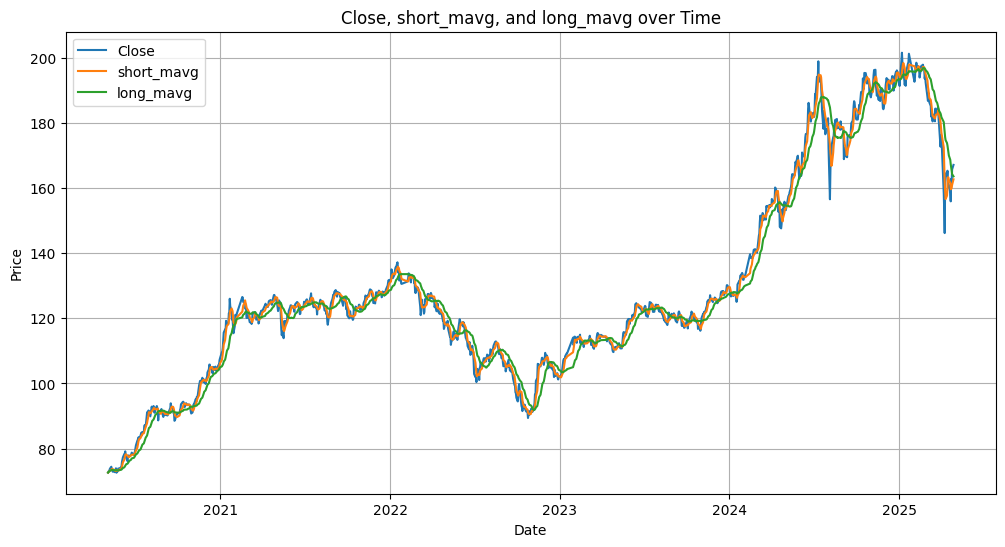

In [14]:
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(dataset['Date'], dataset['Close'], label='Close')
plt.plot(dataset['Date'], dataset['short_mavg'], label='short_mavg')
plt.plot(dataset['Date'], dataset['long_mavg'], label='long_mavg')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Close, short_mavg, and long_mavg over Time')
plt.legend()
plt.grid(True)
plt.show()

<a id='3.3'></a>
## 4.3. Feature Engineering

We begin by the constructing a dataset that contains the predictors which will be used to make the predictions, and the output variable.

The current Data of the bicoin consists of date, open, high, low, close and Volume. Using this data we calculate the following  technical indicators:
* **Moving Average** : A moving average provides an indication of the trend of the price movement by cut down the amount of "noise" on a price chart.
* **Stochastic Oscillator %K and %D** : A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. %K and %D are slow and fast indicators.
* **Relative Strength Index(RSI)** :It is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset.
* **Rate Of Change(ROC)**: It is a momentum oscillator, which measures the percentage change between the current price and the n period past price.
* **Momentum (MOM)** : It is the rate of acceleration of a security's price or volume – that is, the speed at which the price is changing.

In [15]:
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
dataset['EMA10'] = EMA(dataset, 10)
dataset['EMA30'] = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)
dataset.head()

#calculation of rate of change
def ROC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))
    return ROC
dataset['ROC10'] = ROC(dataset['Close'], 10)
dataset['ROC30'] = ROC(dataset['Close'], 30)

#Calculation of price momentum
def MOM(df, n):
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM
dataset['MOM10'] = MOM(dataset['Close'], 10)
dataset['MOM30'] = MOM(dataset['Close'], 30)

#calculation of relative strength index
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
dataset['RSI10'] = RSI(dataset['Close'], 10)
dataset['RSI30'] = RSI(dataset['Close'], 30)
dataset['RSI200'] = RSI(dataset['Close'], 200)

#calculation of stochastic osillator.

def STOK(close, low, high, n):
    # Convert columns to numeric, handling errors
    low = pd.to_numeric(low, errors='coerce')
    high = pd.to_numeric(high, errors='coerce')
    close = pd.to_numeric(close, errors='coerce')

    # Fill NaNs with previous valid numeric values
    low = low.ffill()
    high = high.ffill()
    close = close.ffill()

    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    return STOK

def STOD(close, low, high, n):
    # Convert columns to numeric, handling errors
    low = pd.to_numeric(low, errors='coerce')
    high = pd.to_numeric(high, errors='coerce')
    close = pd.to_numeric(close, errors='coerce')

    # Fill NaNs with previous valid numeric values
    low = low.ffill()
    high = high.ffill()
    close = close.ffill()

    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    STOD = STOK.rolling(3).mean()
    return STOD

dataset['%K10'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%K30'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%K200'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)

In [16]:
#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
dataset['MA21'] = MA(dataset, 21)
dataset['MA63'] = MA(dataset, 63)
dataset['MA252'] = MA(dataset, 252)
dataset.tail()

Price,Date,Close,High,Low,Open,Volume,short_mavg,long_mavg,signal,EMA10,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
1207,2025-04-22,155.95,157.90,155.95,157.55,18910215,159.67,167.387,0.0,161.323,...,48.704,46.203,56.892,26.481,31.571,18.817,23.171,168.129,184.087,180.583
1208,2025-04-23,162.85,163.10,160.30,160.30,15808988,159.77,166.393,0.0,161.601,...,49.633,56.180,53.255,43.696,34.186,30.675,24.288,167.171,183.556,180.608
1209,2025-04-24,161.90,164.05,161.30,163.90,13444117,160.04,165.255,1.0,161.655,...,49.509,49.064,50.482,41.371,37.183,29.042,26.178,166.179,183.082,180.615
1210,2025-04-25,165.75,166.95,165.50,166.20,17640931,161.01,164.318,1.0,162.400,...,50.018,76.863,60.702,50.796,45.288,35.658,31.792,165.279,182.651,180.638
1211,2025-04-28,167.15,167.50,166.80,166.80,12092963,162.72,163.625,1.0,163.264,...,50.201,96.970,74.299,54.691,48.953,38.064,34.255,164.452,182.265,180.668


In [17]:
dataset.tail()

Price,Date,Close,High,Low,Open,Volume,short_mavg,long_mavg,signal,EMA10,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
1207,2025-04-22,155.95,157.90,155.95,157.55,18910215,159.67,167.387,0.0,161.323,...,48.704,46.203,56.892,26.481,31.571,18.817,23.171,168.129,184.087,180.583
1208,2025-04-23,162.85,163.10,160.30,160.30,15808988,159.77,166.393,0.0,161.601,...,49.633,56.180,53.255,43.696,34.186,30.675,24.288,167.171,183.556,180.608
1209,2025-04-24,161.90,164.05,161.30,163.90,13444117,160.04,165.255,1.0,161.655,...,49.509,49.064,50.482,41.371,37.183,29.042,26.178,166.179,183.082,180.615
1210,2025-04-25,165.75,166.95,165.50,166.20,17640931,161.01,164.318,1.0,162.400,...,50.018,76.863,60.702,50.796,45.288,35.658,31.792,165.279,182.651,180.638
1211,2025-04-28,167.15,167.50,166.80,166.80,12092963,162.72,163.625,1.0,163.264,...,50.201,96.970,74.299,54.691,48.953,38.064,34.255,164.452,182.265,180.668


In [18]:
#excluding columns that are not needed for our prediction.

dataset=dataset.drop(['High','Low','Open', 'short_mavg','long_mavg'], axis=1)

In [19]:
dataset = dataset.dropna(axis=0)

In [20]:
dataset.tail()

Price,Date,Close,Volume,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
1207,2025-04-22,155.95,18910215,0.0,161.323,170.650,178.989,6.669,-15.816,2.70,...,48.704,46.203,56.892,26.481,31.571,18.817,23.171,168.129,184.087,180.583
1208,2025-04-23,162.85,15808988,0.0,161.601,170.147,178.828,1.275,-10.522,16.65,...,49.633,56.180,53.255,43.696,34.186,30.675,24.288,167.171,183.556,180.608
1209,2025-04-24,161.90,13444117,1.0,161.655,169.615,178.660,-1.610,-11.433,1.10,...,49.509,49.064,50.482,41.371,37.183,29.042,26.178,166.179,183.082,180.615
1210,2025-04-25,165.75,17640931,1.0,162.400,169.365,178.531,1.252,-8.476,1.20,...,50.018,76.863,60.702,50.796,45.288,35.658,31.792,165.279,182.651,180.638
1211,2025-04-28,167.15,12092963,1.0,163.264,169.222,178.418,1.089,-7.396,3.45,...,50.201,96.970,74.299,54.691,48.953,38.064,34.255,164.452,182.265,180.668


<a id='3.4'></a>
## 4.4. Data Visualization

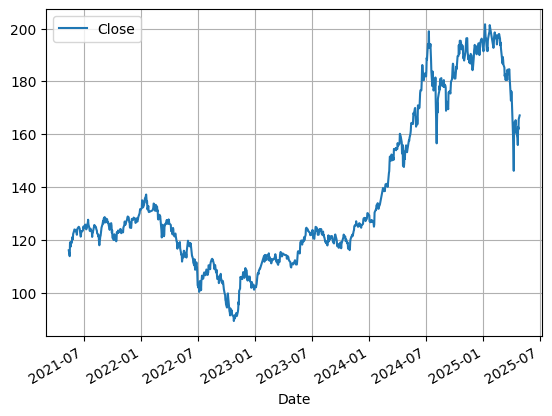

In [21]:
# Assuming 'Date' was originally the index, reset it to a column
dataset = dataset.reset_index()

# Now you can plot
dataset.plot(x='Date', y='Close', grid=True)
plt.show()

In [22]:
dataset = dataset.drop('index', axis=1)

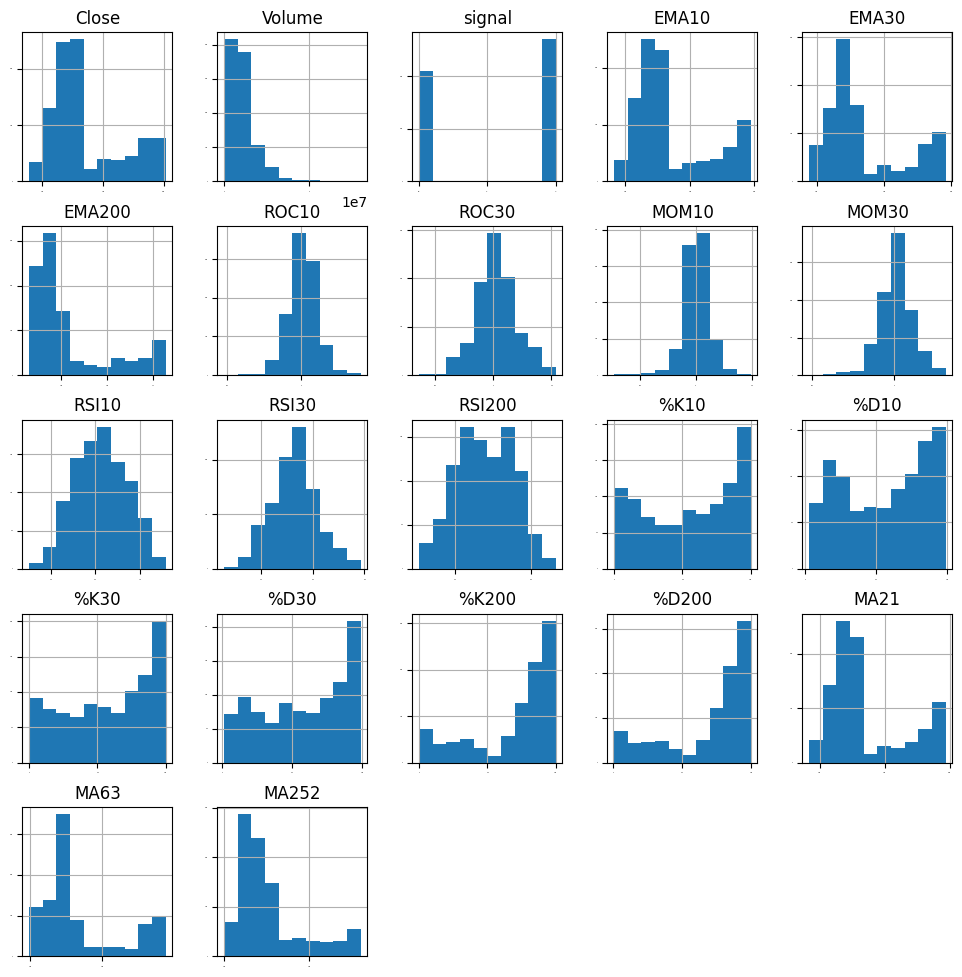

In [23]:
# Select only numeric columns, excluding 'Date'
numeric_data = dataset.select_dtypes(include=np.number)
numeric_data = numeric_data.drop(columns=['Date'], errors='ignore')  # Remove 'Date' if present

# Plot histograms for the remaining numeric columns
numeric_data.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12, 12))
plt.show()

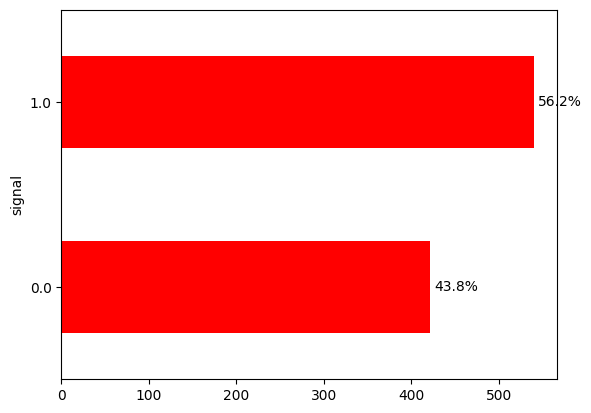

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure()
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')

# Get total count
total = len(dataset)

# Add percentages as text on the bars
for p in plot.patches:
    width = p.get_width()  # Get bar width (count)
    height = p.get_height()
    x, y = p.get_xy()  # Get bar position
    plot.annotate(f'{width/total:.1%}', (x + width + 5, y + height/2),
                  ha='left', va='center', color='black')  # Annotate with percentage

plt.show()

The predicted variable is upward 56% out of total data-size, meaning that number
of the buy signals were more than the number of sell signals.

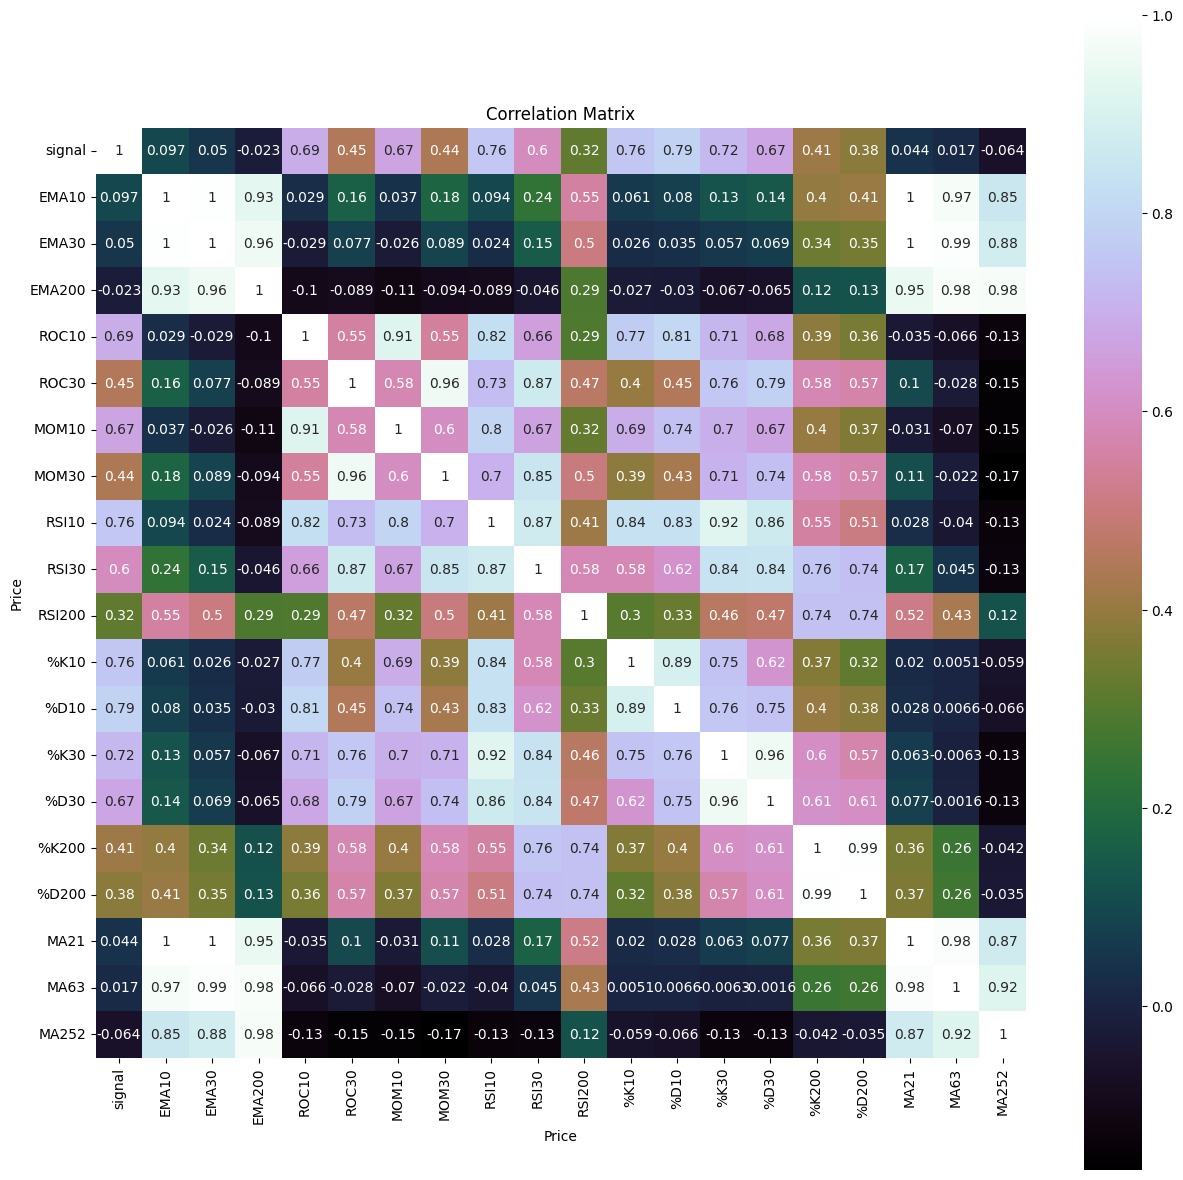

In [25]:
# Select only numeric columns, excluding 'Close', 'Volume'
correlation = dataset.drop(columns=['Close', 'Volume']).select_dtypes(include=np.number).corr()

plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')
plt.show() # Add this line to display the plot

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split

We split the dataset into 80% training set and 20% test set.

In [26]:
# split out validation dataset for the end
Y= dataset["signal"]
#X = dataset.loc[:, dataset.columns != 'signal']

# Select only numerical features for X
numerical_features = dataset.select_dtypes(include=np.number).columns.tolist()
numerical_features.remove('signal')  # Remove the target variable from features
numerical_features.remove('Volume')  # Remove 'Volume'
numerical_features.remove('Close')  # Remove 'Close'
X = dataset[numerical_features]

test_size = 0.2
seed = 1
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=1)

<a id='4.2'></a>
## 5.2. Test Options and Evaluation Metrics


In [27]:
# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring ='neg_log_loss'
#scoring = 'roc_auc'

<a id='4.3'></a>
## 5.3. Compare Models and Algorithms

In order to know which algorithm technic is the best for our strategy, we evaluate following non linear different methods:

<a id='4.3.1'></a>
### 5.3.1. Models

In [28]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

### K-folds cross validation

In [29]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.914029 (0.029358)
LDA: 0.917977 (0.022579)
KNN: 0.903640 (0.034009)
CART: 0.880280 (0.023541)
NB: 0.890619 (0.024115)
NN: 0.888055 (0.027852)
AB: 0.907570 (0.025101)
GBM: 0.923206 (0.023550)
RF: 0.925820 (0.031936)


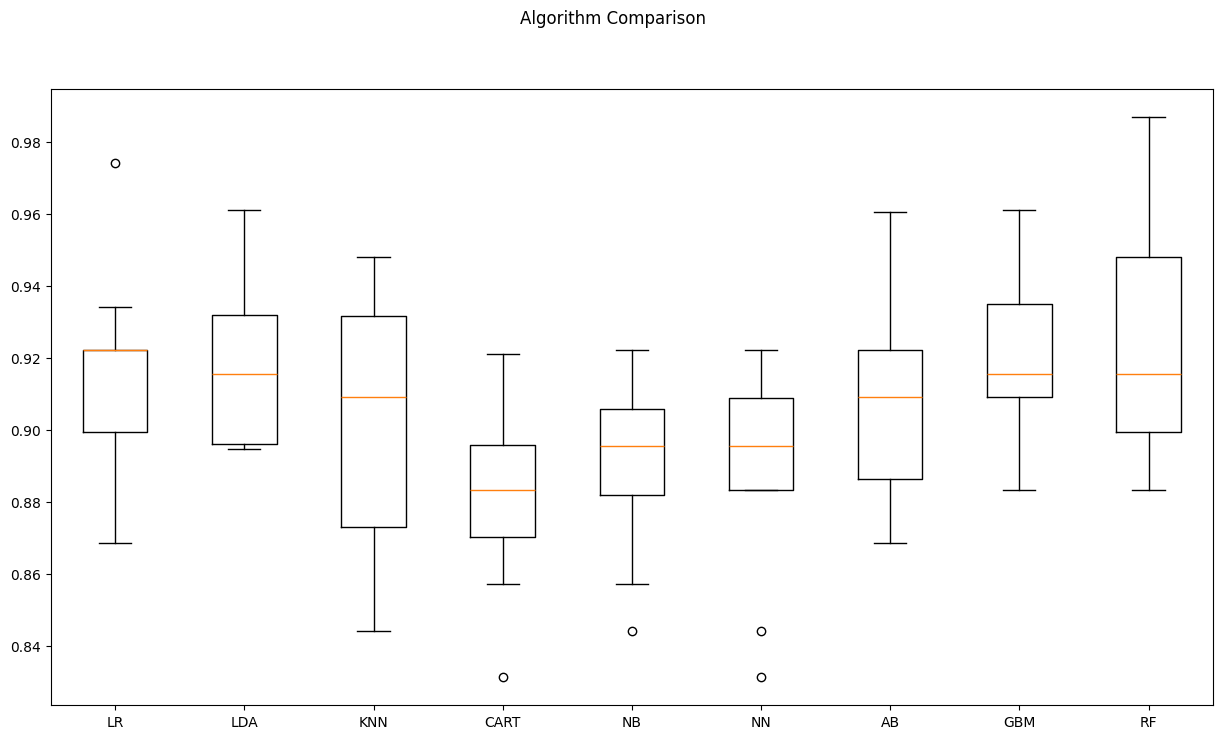

In [30]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

<a id='5'></a>
# 6. Model Tuning and Grid Search

In [31]:
# Grid Search: Logistic Regression

# Scale the training data using only numerical features
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

# Define the parameter grid for Logistic Regression
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'saga'],  # Solvers that support both l1 and l2 penalties
    'max_iter': [100, 500, 1000]
}

# Create a Logistic Regression model
model = LogisticRegression(n_jobs=-1)

# Keep the KFold setup the same
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

# Perform Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

# Print results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.919258 using {'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
#82 0.432211 (0.056556) with: {'C': 0.001, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
#79 0.567789 (0.056556) with: {'C': 0.001, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
#73 0.889320 (0.026817) with: {'C': 0.001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
#76 0.873701 (0.024763) with: {'C': 0.001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
#82 0.432211 (0.056556) with: {'C': 0.001, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
#79 0.567789 (0.056556) with: {'C': 0.001, 'max_iter': 500, 'penalty': 'l1', 'solver': 'saga'}
#73 0.889320 (0.026817) with: {'C': 0.001, 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}
#76 0.873701 (0.024763) with: {'C': 0.001, 'max_iter': 500, 'penalty': 'l2', 'solver': 'saga'}
#82 0.432211 (0.056556) with: {'C': 0.001, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
#79 0.567789 (0.056556) with: {'C':

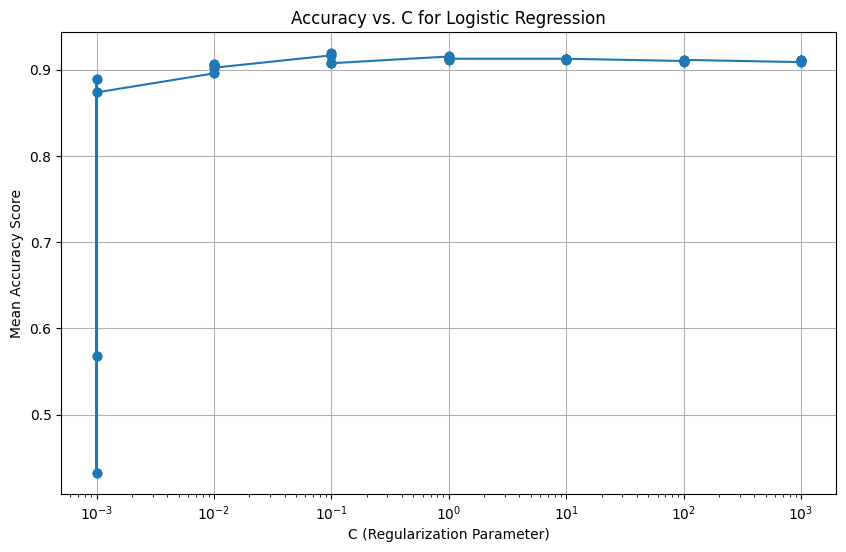

In [32]:
# Check model fit
# Extract relevant data from grid_result
C_values = [params['C'] for params in grid_result.cv_results_['params']]
mean_scores = grid_result.cv_results_['mean_test_score']

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(C_values, mean_scores, marker='o', linestyle='-')
plt.xscale('log')  # Use logarithmic scale for x-axis to better visualize wide range of C values
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Mean Accuracy Score')
plt.title('Accuracy vs. C for Logistic Regression')
plt.grid(True)
plt.show()

Logistic Regression is selected for the grid search as it is one of the best models out of all.

<a id='6'></a>
# 7. Finalise the Model

Finalizing the model with best parameters found during tuning step.

<a id='6.1'></a>
## 7.1. Results on the Test Dataset

In [39]:
# prepare model
model = LogisticRegression(C=0.1, max_iter=100, penalty='l1', solver='saga', n_jobs=-1)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
model.fit(X_train_scaled, Y_train)

LogisticRegression(C=0.1, n_jobs=-1, penalty='l1', solver='saga')

In [40]:
# accuracy on test set
predictions = model.predict(X_test_scaled)
print(accuracy_score(Y_test, predictions))
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

0.8911917098445595
[[78 11]
 [10 94]]
              precision    recall  f1-score   support

         0.0       0.89      0.88      0.88        89
         1.0       0.90      0.90      0.90       104

    accuracy                           0.89       193
   macro avg       0.89      0.89      0.89       193
weighted avg       0.89      0.89      0.89       193



<Axes: xlabel='Predicted', ylabel='Actual'>

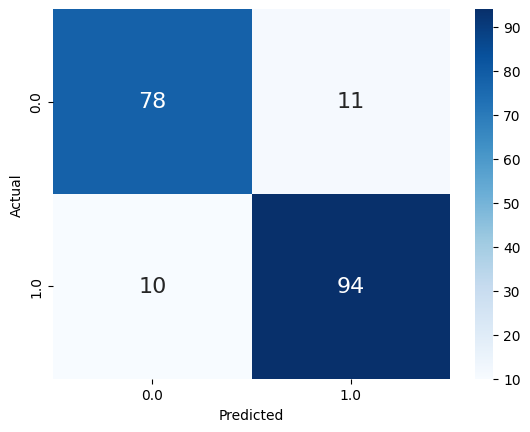

In [41]:
df_cm = pd.DataFrame(confusion_matrix(Y_test, predictions), columns=np.unique(Y_test), index = np.unique(Y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

<a id='6.2'></a>
## 7.2. Variable Intuition/Feature Importance
Let us look into the Feature Importance of the model

Text(0.5, 0, 'Variable Importance')

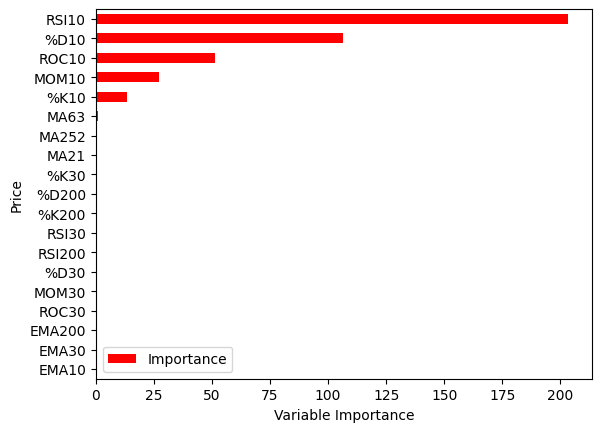

In [42]:
# Use coef_ to get the coefficients
Importance = pd.DataFrame({'Importance':model.coef_[0]}, index=X.columns)
Importance['Importance'] = Importance['Importance'] * 100  # scale by 100

# Plot the importance values:
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r')
plt.xlabel('Variable Importance')

<a id='7'></a>
## 8. Backtesting Results

<Axes: >

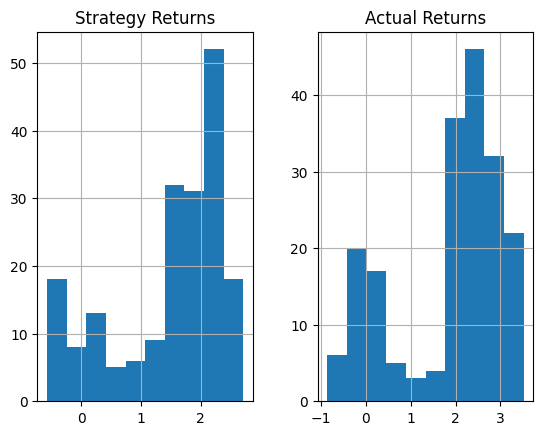

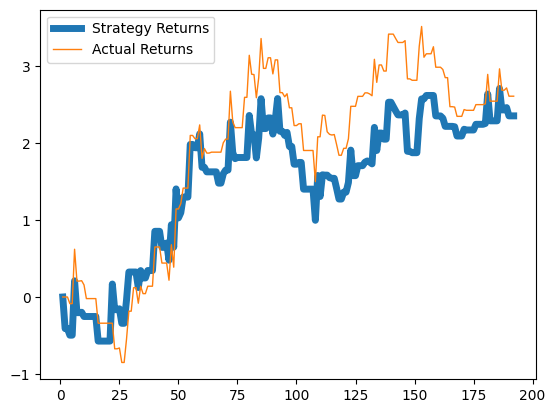

In [43]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata = pd.DataFrame(index=X_test.index)
#backtestdata = pd.DataFrame()
backtestdata['signal_pred'] = predictions
backtestdata['signal_actual'] = Y_test
# Instead of using X_test['Close'], use the original dataset
# Reset index of dataset to match X_test if they are different
dataset = dataset.reset_index()
backtestdata = backtestdata.reset_index()
# Now use the common 'index' column for merging
backtestdata = pd.merge(backtestdata, dataset[['index', 'Close']], on='index', how='left')
# Calculate percentage change on the merged 'Close' column
backtestdata['Market Returns'] = backtestdata['Close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata=backtestdata.drop(columns=['index', 'Close']) # Drop temporary columns
backtestdata.head()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns']].cumsum().plot(linewidth=5)  # Plot 'Strategy Returns' with linewidth 2
backtestdata[['Actual Returns']].cumsum().plot(linewidth=1, ax=plt.gca())  # Plot 'Actual Returns' on the same axes with linewidth 1

In [44]:
# Calculate cumulative returns
cumulative_strategy_returns = backtestdata['Strategy Returns'].cumsum()
cumulative_actual_returns = backtestdata['Actual Returns'].cumsum()

# Calculate percentage of cumulative strategy returns over actual returns
percentage_returns = (cumulative_strategy_returns / cumulative_actual_returns) * 100

# Remove NaN values before accessing the last element
percentage_returns = percentage_returns.dropna()

# Print or display the result
print(f"Percentage of Cumulative Strategy Returns over Actual Returns: {percentage_returns.iloc[-1]:.2f}%")
# Access the last element for the final percentage using iloc

# Alternatively, to see the percentage over time:
# percentage_returns.plot(title='Percentage of Cumulative Strategy Returns over Actual Returns')
#plt.show()

Percentage of Cumulative Strategy Returns over Actual Returns: 90.20%


__Conclusion__:

We showed that framing the problem is the first priority and we address it by engineering the features and transforming the labels according to the investment objective.

We demonstrated the efficiency of using feature engineering that leads to creation of
intuitive features related to the trend and momentum of the price movement and
increases the predictive power of the model.

In terms of the evaluation metrics for a classification-based trading strategy, accuracy
or auc are appropriate, but in case the strategy is focusing to be more accurate while
going long, the metric recall which focuses on less false positive can be preferred as
compared to accuracy.

Finally, we demonstrated the backtesting framework which allows us to simulate a trading strategy using historical data to generate results and analyze risk and profitability before risking any actual capital.
